# Krylov type of methods for solving Laplace equations in 2D

Laplace equation with Dirichlet boundary condition

$$-\Delta u(x,y) = f(x,y), \quad (x,y)\in \Omega=[0,1]^2,\quad u\vert_\partial\Omega = 0$$

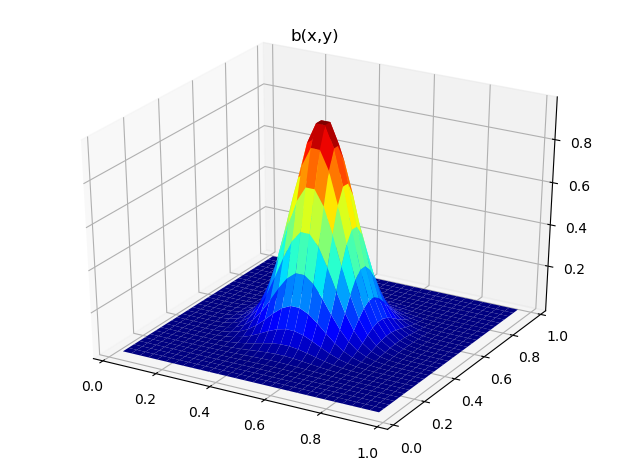

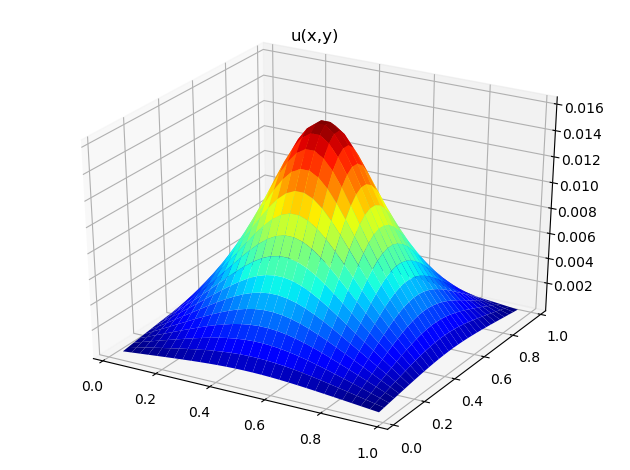

PyObject Text(0.5,0.92,'u(x,y)')

In [112]:
using LinearAlgebra
using SparseArrays

# Setup for the matrix
N = 30
h = 1.0 / (N+1)
x1d = collect(1:N)*h
sI_N = sparse(1.0I,N,N)

# Full 2D Laplacian on the entire square
A1D = 1.0/h^2*spdiagm(-1=>-ones(N-1),0=>2.0*ones(N),1=>-ones(N-1))
A2D = kron(A1D,sI_N)+kron(sI_N,A1D)

sigma = 0.1
b = [exp.(-((x1d[i]-0.5)^2 + (x1d[j]-0.5)^2) / (2*sigma^2)) for i = 1 : N, j = 1 : N] 
b = reshape(b,N*N)
uexact = A2D\b
x0 = zeros(N*N)

using PyPlot
figure(1)
surf(x1d,x1d,reshape(b,N,N),edgecolors="none",cmap=ColorMap("jet"),shade="true")
title("b(x,y)")

figure(2)
surf(x1d,x1d,reshape(uexact,N,N),edgecolors="none",cmap=ColorMap("jet"),shade="true")
title("u(x,y)")

## What would the number of iterations change if one increases N for SD and CG?

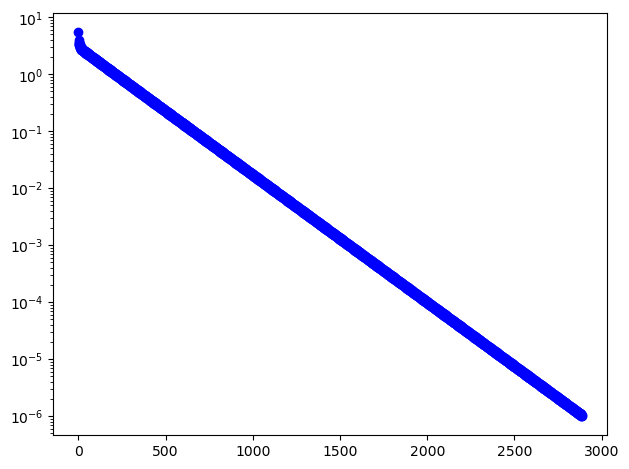

Error ||u-uexact||_2 = 3.66166193760024e-8


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc5840ce668>

In [42]:
# Steepest descent method for Laplace's equation

function SD(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r = b - A * x
    nrmr = r' * r
    
    errhist = zeros(maxiter)
    iter = 0
    while(iter < maxiter)
        iter += 1
        Ar = A * r
        alpha = nrmr / (r' * Ar)
        x = x + alpha * r
        r = r - alpha * Ar
        nrmrnew  = r' * r;
        errhist[iter] = sqrt(nrmrnew)
        if sqrt(nrmrnew) < tol
              break
        end
        nrmr = nrmrnew
    end
    errhist = errhist[1:iter]
    return x, errhist
end

uSD,errhistSD = SD(A2D,b,x0,1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(uSD-uexact))

figure(1)
semilogy(errhistSD,"b-o")

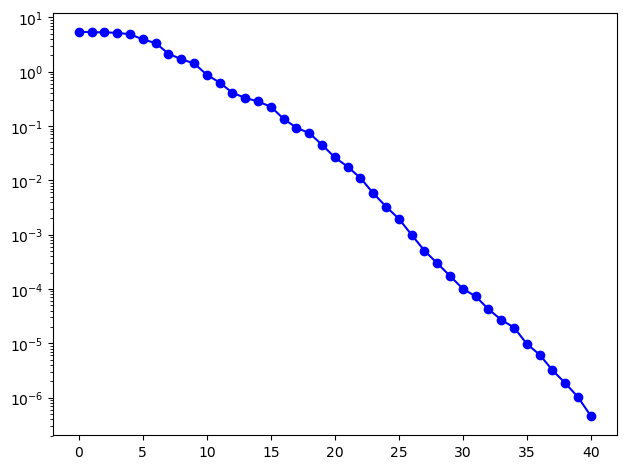

Error ||u-uexact||_2 = 2.3956891866142043e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc56a063470>

In [113]:
function CG(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r = b - A * x
    p = r
    nrmr = r' * r
    errhist = zeros(maxiter)
    iter = 0
    while( iter < maxiter )
        iter += 1
        Ap = A * p
        alpha = nrmr / (p' * Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        nrmrnew  = r' * r;
        errhist[iter] = sqrt(nrmrnew)
        if sqrt(nrmrnew) < tol
              break
        end
        p = r + (nrmrnew / nrmr) * p
        nrmr = nrmrnew
    end
    errhist = errhist[1:iter]
    return x, errhist
end

uCG,errhistCG = CG(A2D,b,x0,1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(uCG-uexact))
figure(1)
semilogy(errhistCG,"b-o")

5×5 Array{Float64,2}:
 98.7105   97.4431    5.5124e-14   -6.34377e-14    4.60471e-14
 97.4431  286.186   187.632        -1.32544e-13    1.18895e-13
  0.0     187.632   460.056       271.46          -4.74201e-14
  0.0       0.0     271.46        623.023        348.989      
  0.0       0.0       0.0         348.989        785.344      

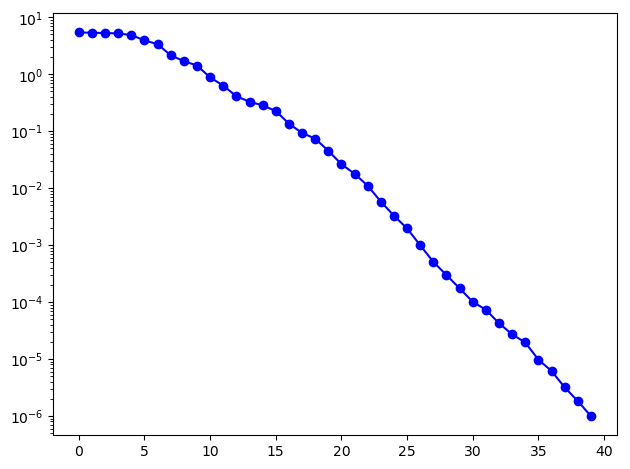

Error ||u-uexact||_2 = 4.714361416562497e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc56e5cdfd0>

In [105]:
# FOM method.
# This is a demonstration implementation and there is no restart
# This is also the most inefficient implementation.

function FOMFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    V = zeros(N,maxiter)
    H = zeros(maxiter,maxiter-1)
    Av = zeros(N)
    nrmr0 = norm(r0)
    V[:,1] = r0 / nrmr0
    k = 0
    errhist = zeros(maxiter)
    
    while( k < maxiter - 1 )
        k += 1
        Av = A*V[:,k]
        # Modified Gram-Schmidt for orthogonalization
        for j = 1 : k
            H[j,k] = dot(V[:,j],Av)
            Av -= H[j,k] * V[:,j]
        end
        H[k+1,k] = norm(Av)
        V[:,k+1] = Av/H[k+1,k]

        e1 = zeros(k)
        e1[1] = 1.0
        b1 = e1*nrmr0
        y = H[1:k,1:k]\b1
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = sqrt(r'*r)
        errhist[k] = nrmrnew
        if(abs(H[k+1,k])<1e-12 || nrmrnew < tol)
            break
        end        
    end
    errhist = errhist[1:k]
    
    # Show symmetry pattern
    display(H[1:5,1:5])
    
    return x,errhist
end

u,errhist = FOMFull(A2D,b,x0,1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")

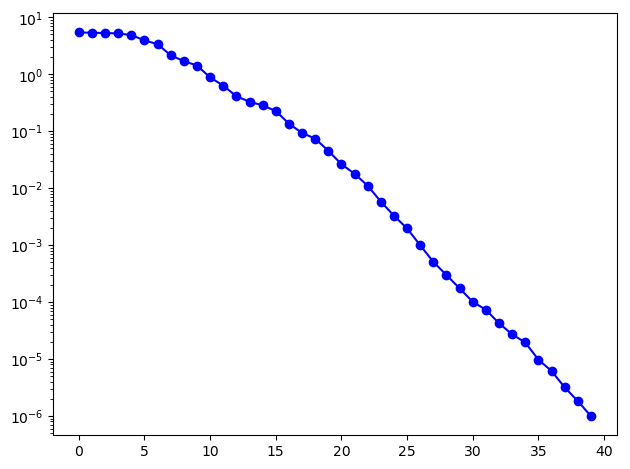

Error ||u-uexact||_2 = 4.714364218325666e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc5847dcb38>

In [27]:
# Lanczos method. This is equivalent to CG.
# This is a demonstration implementation and there is no restart
# This is also the most inefficient implementation.

function LanczosFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    Av = zeros(N)
    nrmr0 = norm(r0)
    V = zeros(N,maxiter)
    V[:,1] = r0 / nrmr0
    errhist = zeros(maxiter)
    e1 = zeros(maxiter)
    e1[1] = 1.0
    b1 = e1*nrmr0
    T = spzeros(maxiter,maxiter)

    k = 0

    while( k < maxiter )
        k += 1
        Av = A*V[:,k]
        # Lanczos implementation is simplier than Arnoldi
        # and is equivalent for SPD problems.
        if( k == 1 )
            w = Av
        else
            w = Av - T[k-1,k]*V[:,k-1]
        end
        T[k,k] = dot(w,V[:,k])
        w -= T[k,k]*V[:,k]
        T[k+1,k] = norm(w)
        T[k,k+1] = T[k+1,k]
        V[:,k+1] = w/T[k+1,k]
        
        y = T[1:k,1:k]\b1[1:k]
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = sqrt(r'*r)
        errhist[k] = nrmrnew
        if(abs(T[k+1,k])<1e-12 || nrmrnew < tol)
            break
        end       
    end
    errhist = errhist[1:k]
        
    return x,errhist
end

u,errhist = LanczosFull(A2D,b,x0,1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")

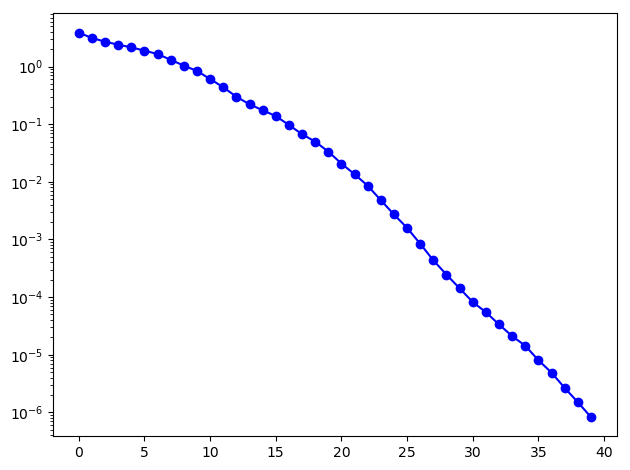

Error ||u-uexact||_2 = 7.193306823439391e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc584b564e0>

In [23]:
# GMRES method.
# This is a demonstration implementation and there is no restart
# This is also the most inefficient implementation, in the sense
# that the QR is done at each iteration. 

function gmresFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    V = zeros(N,maxiter)
    H = zeros(maxiter,maxiter-1)
    Av = zeros(N)
    nrmr0 = norm(r0)
    V[:,1] = r0 / nrmr0
    k = 0
    errhist = zeros(maxiter)
    while( k < maxiter )
        k += 1
        Av = A*V[:,k]
        # Modified Gram-Schmidt for orthogonalization
        for j = 1 : k
            H[j,k] = dot(V[:,j],Av)
            Av -= H[j,k] * V[:,j]
        end
        H[k+1,k] = norm(Av)
        V[:,k+1] = Av/H[k+1,k]

        Q,R=qr(H[1:k+1,1:k])
        Q = Matrix(Q)
        y = zeros(k,1)
        b1 = vec(Q[1,:])*nrmr0
        y = R\b1
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = r'*r
        errhist[k] = sqrt(nrmrnew)
        if(abs(H[k+1,k])<1e-12 || sqrt(nrmrnew) < tol)
            break
        end    
    end
    errhist = errhist[1:k]
    return x,errhist
end

u,errhist = gmresFull(A2D,b,x0,1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")

## Preconditioned methods

In [84]:
# Preconditioned steepest descent method

function PSD(A,b,x0,M,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r = b - A * x
    nrmr = r' * r
    
    errhist = zeros(maxiter)
    iter = 0
    while(iter < maxiter)
        iter += 1
        z = M \ r
        Az = A * z
        alpha = (r'*z) / (z' * Az)
        x = x + alpha * z
        r = r - alpha * Az
        nrmrnew  = r' * r;
        errhist[iter] = sqrt(nrmrnew)
        if sqrt(nrmrnew) < tol
              break
        end
        nrmr = nrmrnew
    end
    errhist = errhist[1:iter]
    return x, errhist
end

#Minv = spdiagm(0=>1 ./ Vector(diag(A2D)))
# Potential term
Vext = 1000.0* [exp.(-((x1d[i]-0.5)^2 + (x1d[j]-0.5)^2) / (2*sigma^2)) for i = 1 : N, j = 1 : N] 
Vext = reshape(Vext,N*N)

H = A2D + spdiagm(0=>Vext);

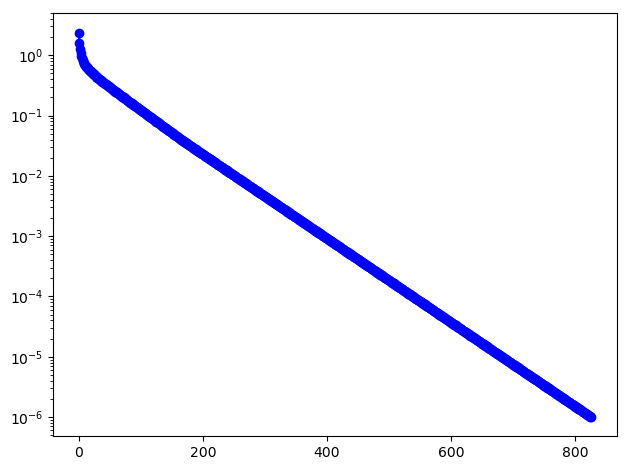

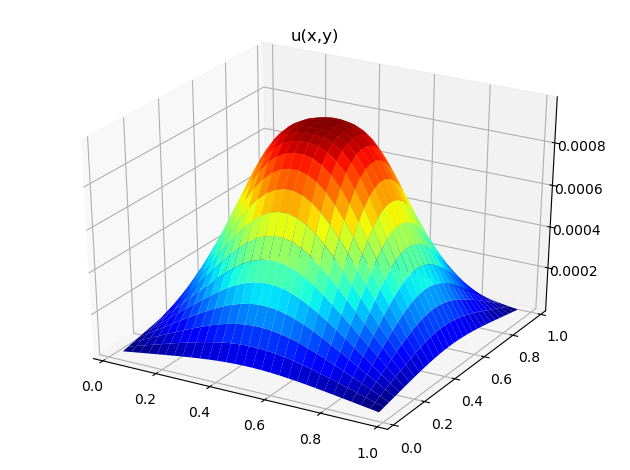

Error ||u-uexact||_2 = 0.16820383468065542


PyObject Text(0.5,0.92,'u(x,y)')

In [85]:
# No preconditioner
uSD,errhistSD = PSD(H,b,x0,sparse(1.0I,N^2,N^2),1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(uSD-uexact))

figure(1)
semilogy(errhistSD,"b-o")

figure(2)
surf(x1d,x1d,reshape(uSD,N,N),edgecolors="none",cmap=ColorMap("jet"),shade="true")
title("u(x,y)")

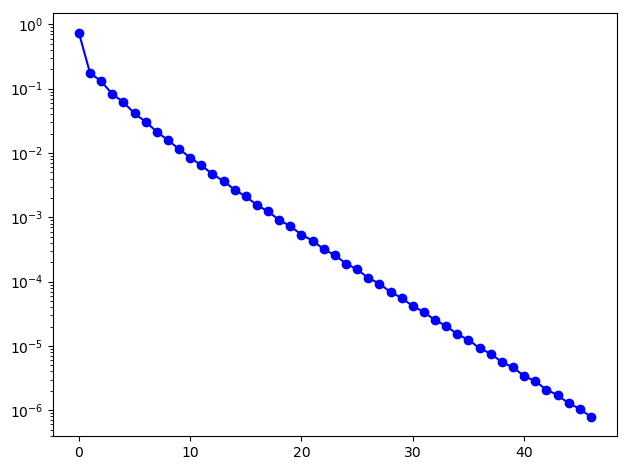

Error ||u-uexact||_2 = 0.16820382931503036


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc56f6f7cc0>

In [86]:

# Preconditioning with inverse Laplace
uSD,errhistSD = PSD(H,b,x0,A2D,1e-6,10000)
println("Error ||u-uexact||_2 = ", norm(uSD-uexact))

figure(1)
semilogy(errhistSD,"b-o")

In [94]:
# Preconditioned conjugate gradient

function PCG(A,b,x0,M,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r = b - A * x
    z = M \ r
    p = z
    nrmr = r' * r
    rho  = r' * z
    errhist = zeros(maxiter)
    iter = 0
    while( iter < maxiter )
        iter += 1
        Ap = A * p
        alpha = rho / (p' * Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        nrmrnew  = r' * r
        errhist[iter] = sqrt(nrmrnew)
        if sqrt(nrmrnew) < tol
              break
        end
        z = M \ r
        rhonew   = r' * z
        p = z + (rhonew / rho) * p
        nrmr = nrmrnew
        rho  = rhonew
    end
    errhist = errhist[1:iter]
    return x, errhist
end

PCG (generic function with 3 methods)

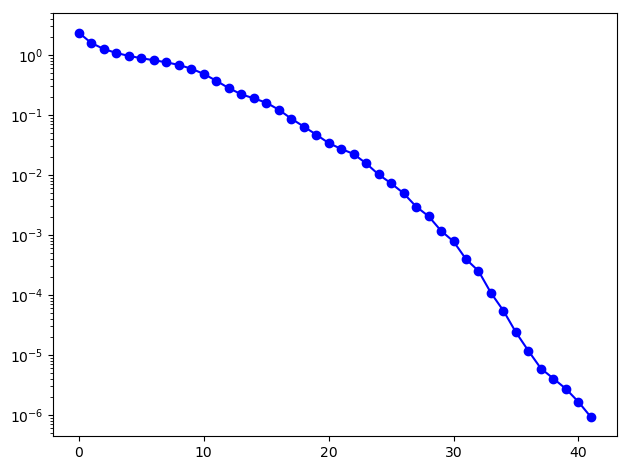

Error ||u-uexact||_2 = 0.16820382791823146


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc56ebcd9e8>

In [98]:
uCG,errhistCG = PCG(H,b,x0,sparse(1.0I, N^2,N^2), 1e-6,10000)

println("Error ||u-uexact||_2 = ", norm(uCG-uexact))
figure(1)
semilogy(errhistCG,"b-o")

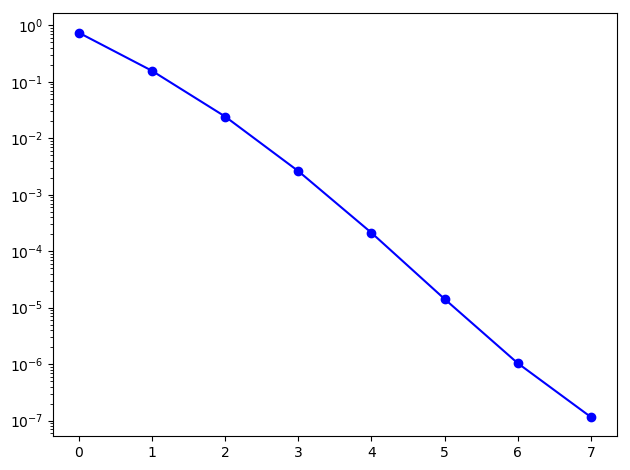

Error ||u-uexact||_2 = 0.1682038279247684


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc56f605c50>

In [97]:
uCG,errhistCG = PCG(H,b,x0,A2D, 1e-6,10000)

println("Error ||u-uexact||_2 = ", norm(uCG-uexact))
figure(1)
semilogy(errhistCG,"b-o")